
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/057_Metric_Learning_Siamese.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/57_Metric_Learning_Siamese.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 📏 Metric Learning: Jak działa FaceID? (Siamese Networks)

W klasyfikacji pytamy: *"Czy to jest Jan?"*.
W Metric Learningu pytamy: *"Jaka jest odległość między tymi dwoma zdjęciami?"*.

*   Jeśli odległość < 0.5 -> To ta sama osoba (Otwórz telefon).
*   Jeśli odległość > 0.5 -> To ktoś inny (Zablokuj).

**Architektura Syjamska:**
Mamy **jedną** sieć neuronową.
Przepuszczamy przez nią dwa zdjęcia (jedno po drugim). Otrzymujemy dwa wektory (embeddingi). Liczymy dystans między nimi.

**Triplet Loss (Klucz do sukcesu):**
Uczymy sieć na trójkach:
1.  **Anchor (A):** Zdjęcie referencyjne (np. Jan).
2.  **Positive (P):** Inne zdjęcie tej samej osoby (Jan w okularach).
3.  **Negative (N):** Zdjęcie kogoś innego (Anna).

Cel matematyczny:
$$ Dystans(A, P) + Margin < Dystans(A, N) $$
(Jan ma być bliżej Jana niż Anny, z zachowaniem marginesu bezpieczeństwa).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Konfiguracja
EMBED_DIM = 2 # Zrobimy embeddingi 2D, żeby łatwo je narysować na wykresie
MARGIN = 1.0  # Margines bezpieczeństwa w Triplet Loss

print("Gotowi do budowy sieci syjamskiej.")

Gotowi do budowy sieci syjamskiej.


## Krok 1: Sieć Embedująca (Backbone)

To jest zwykła sieć (może to być CNN, może być MLP). Jej zadaniem jest zamiana "wejścia" (np. obrazka) na wektor liczb.
Dla uproszczenia użyjemy prostego MLP, który przyjmuje wektor cech.

In [2]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Prosta sieć: Wejście 10 cech -> Ukryta 32 -> Wyjście 2 (Embedding)
        self.net = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, EMBED_DIM) # Brak aktywacji na końcu! Chcemy surowe liczby.
        )

    def forward(self, x):
        return self.net(x)

# Inicjalizacja (To jest ta JEDNA sieć, której użyjemy 3 razy)
model = EmbeddingNet()
print(model)

EmbeddingNet(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=2, bias=True)
  )
)


## Krok 2: Triplet Loss (Serce układu)

Zaimplementujemy matematykę Triplet Loss od zera.
$$ Loss = \max(0, d(A, P) - d(A, N) + margin) $$

*   $d(A, P)$: Odległość między Kotwicą a Pozytywem (chcemy małą).
*   $d(A, N)$: Odległość między Kotwicą a Negatywem (chcemy dużą).
*   **Margin:** Chcemy, żeby Negatyw był nie tylko "trochę dalej", ale "dużo dalej" (o wartość marginesu).

In [3]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # 1. Liczymy odległości (Euklidesowe)
        # Pairwise distance: sqrt(sum((x-y)^2))
        dist_ap = F.pairwise_distance(anchor, positive)
        dist_an = F.pairwise_distance(anchor, negative)
        
        # 2. Wzór Triplet Loss
        # relu(x) to to samo co max(0, x)
        loss = F.relu(dist_ap - dist_an + self.margin)
        
        return loss.mean() # Średnia z batcha

criterion = TripletLoss(margin=MARGIN)
print("Funkcja kosztu gotowa.")

Funkcja kosztu gotowa.


## Symulacja Treningu

Stwórzmy sztuczne dane.
*   **Anchor (A):** Punkt [1, 1, ...] (Osoba X)
*   **Positive (P):** Punkt [1.1, 0.9, ...] (Osoba X w innym świetle)
*   **Negative (N):** Punkt [5, 5, ...] (Osoba Y - zupełnie inna)

Na początku (przed treningiem) sieć rzutuje je losowo. Zobaczmy, jak zadziała Loss.

In [4]:
# Generujemy losowe dane wejściowe (Batch size = 1)
anchor_input = torch.randn(1, 10)
# Pozytyw jest trochę podobny do Anchora (dodajemy mały szum)
positive_input = anchor_input + torch.randn(1, 10) * 0.1
# Negatyw jest zupełnie inny
negative_input = torch.randn(1, 10)

# OPTYMALIZATOR
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("--- TRENING (Symulacja 100 kroków) ---")

for i in range(100):
    optimizer.zero_grad()
    
    # 1. Przepuszczamy WSZYSTKIE trzy przez TĘ SAMĄ sieć
    emb_a = model(anchor_input)
    emb_p = model(positive_input)
    emb_n = model(negative_input)
    
    # 2. Liczymy stratę
    loss = criterion(emb_a, emb_p, emb_n)
    
    # 3. Aktualizacja wag
    loss.backward()
    optimizer.step()
    
    if i % 20 == 0:
        dist_ap = F.pairwise_distance(emb_a, emb_p).item()
        dist_an = F.pairwise_distance(emb_a, emb_n).item()
        print(f"Krok {i}: Loss={loss.item():.4f} | D(A,P)={dist_ap:.4f} | D(A,N)={dist_an:.4f}")

print("\nWNIOSEK:")
print("Zauważ, jak D(A,P) maleje (zbliżają się), a D(A,N) rośnie (oddalają się).")

--- TRENING (Symulacja 100 kroków) ---
Krok 0: Loss=0.8797 | D(A,P)=0.0025 | D(A,N)=0.1227
Krok 20: Loss=0.0000 | D(A,P)=0.0418 | D(A,N)=6.0109
Krok 40: Loss=0.0000 | D(A,P)=0.0568 | D(A,N)=7.4743
Krok 60: Loss=0.0000 | D(A,P)=0.0593 | D(A,N)=7.7163
Krok 80: Loss=0.0000 | D(A,P)=0.0597 | D(A,N)=7.7518

WNIOSEK:
Zauważ, jak D(A,P) maleje (zbliżają się), a D(A,N) rośnie (oddalają się).


## Wizualizacja Przestrzeni (Embedding Space)

Zobaczmy, gdzie wylądowały nasze punkty na płaszczyźnie 2D po treningu.
Oczekujemy, że Anchor i Positive będą blisko siebie, a Negative daleko.

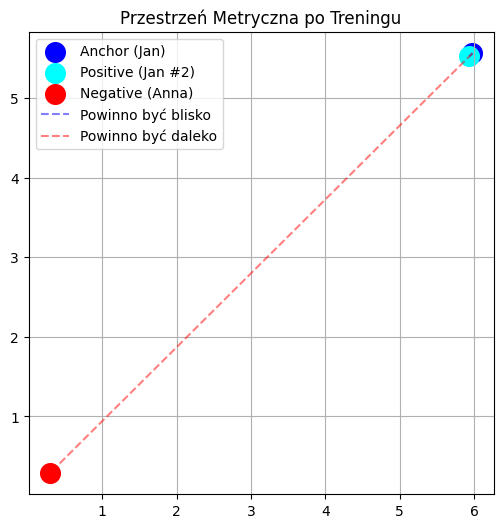

In [5]:
# Pobieramy finalne wektory
with torch.no_grad():
    a = model(anchor_input).numpy()[0]
    p = model(positive_input).numpy()[0]
    n = model(negative_input).numpy()[0]

plt.figure(figsize=(6, 6))

# Rysujemy punkty
plt.scatter(a[0], a[1], c='blue', s=200, label='Anchor (Jan)')
plt.scatter(p[0], p[1], c='cyan', s=200, label='Positive (Jan #2)')
plt.scatter(n[0], n[1], c='red', s=200, label='Negative (Anna)')

# Rysujemy linie łączące
plt.plot([a[0], p[0]], [a[1], p[1]], 'b--', alpha=0.5, label='Powinno być blisko')
plt.plot([a[0], n[0]], [a[1], n[1]], 'r--', alpha=0.5, label='Powinno być daleko')

plt.title("Przestrzeń Metryczna po Treningu")
plt.legend()
plt.grid(True)
plt.show()

## 🧠 Podsumowanie: One-Shot Learning

Dlaczego to jest rewolucja?
Ponieważ ta sieć nauczyła się **uniwersalnej funkcji podobieństwa**.

Jeśli teraz pokażesz jej zdjęcie Kasi (której nigdy nie widziała podczas treningu) i drugie zdjęcie Kasi, sieć wygeneruje dla nich wektory, które będą blisko siebie.
Nie musisz trenować sieci na Kasi. Sieć wie, co to znaczy "ta sama twarz".

To się nazywa **One-Shot Learning** (uczenie z jednego przykładu). Wystarczy jedno zdjęcie w bazie, żeby system Cię rozpoznał.